# Hyperbolic unitary overlap cost function ADAM gradient descent on MPO

Created 12/11/2024

Objectives:
* Apply ADAM gradient descent algorithm to an MPO along with overlap gradient to see if we can get a decent solution.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [4]:
from functools import reduce

In [637]:
import numpy as np
import pandas as pd

rng = np.random.default_rng()
import matplotlib.pyplot as plt

In [6]:
import re

In [7]:
from SPTOptimization.utils import (
    get_right_identity_environment_from_tp_tensor,
    to_npc_array
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

# Load data

In [8]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [9]:
f_name = DATA_DIR + r"/0_00.h5"

In [10]:
f_name

'../../data/transverse_cluster_200_site_dmrg/0_00.h5'

In [11]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

In [12]:
NUM_SITES=5
BOND_DIMENSION=4
PHYSICAL_DIMENSION=2
LEARNING_RATE = 0.01

In [13]:
total_dimension = PHYSICAL_DIMENSION**NUM_SITES

In [14]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [15]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

In [16]:
def generate_random_w_tensor(dims):
    x1 = np.random.rand(*dims)
    x2 = 1j*np.random.rand(*dims)

    return x1 + x2

In [17]:
edge_dims = [PHYSICAL_DIMENSION,]*2 + [BOND_DIMENSION,]
inner_dims = edge_dims + [BOND_DIMENSION,]

In [18]:
w = generate_random_w_tensor(edge_dims)

In [19]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vR'])

In [20]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>

In [21]:
w_tensors = [w_tensor,]

In [22]:
for _ in range(NUM_SITES-2):
    w = generate_random_w_tensor(inner_dims)
    w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
    
    w_tensors.append(w_tensor)

In [23]:
w = generate_random_w_tensor(edge_dims)

In [24]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL'])

In [25]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>

In [26]:
w_tensors.append(w_tensor)

In [27]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

## Test symmetry case

In [28]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [29]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [30]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [31]:
test_case = SymmetryActionWithBoundaryUnitaries(
    test_psi,
    symmetry_actions[1]*50,
    left_boundary_unitaries=[np_I,]*3,
    right_boundary_unitaries=[np_I,]*3
)

In [32]:
test_case.compute_svd_approximate_expectation()

(-6.371358002176382e-29+0j)

## Functions

In [33]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [34]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t

In [35]:
def unitary_order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [36]:
def unitary_order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [37]:
w_tensors[-1].conj()

<npc.Array shape=(2, 2, 4) labels=['p*', 'p', 'vL*']>

In [38]:
def overlap_right_tensors(w_tensors, b_tensors):
    out = list()

    t = get_right_identity_environment_from_tp_tensor(b_tensors[-1])

    out.append(t)

    b = b_tensors[-1]
    w = w_tensors[-1]
    
    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w.conj().replace_label('vL*', 'vLm'),
        [['p',], ['p*',]]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    for w, b in zip(w_tensors[-2:0:-1], b_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR',]])
        t = npc.tensordot(
            t,
            w.conj().replace_label('vL*', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR*']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])
    
        out.append(t)

    return out[::-1]

### Initialize tensors

In [39]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [40]:
def generate_random_w_tensor(physical_dim, left_virtual_dim=None,
                             right_virtual_dim=None):

    if (left_virtual_dim is None) and (right_virtual_dim is None):
        dims = (physical_dim, physical_dim)
    elif (left_virtual_dim is None):
        dims = (physical_dim, physical_dim, right_virtual_dim)
    elif (right_virtual_dim is None):
        dims = (physical_dim, physical_dim, left_virtual_dim)
    else: 
        dims = (
            physical_dim,
            physical_dim,
            left_virtual_dim,
            right_virtual_dim
        )
    
    X1 = rng.normal(size=dims)
    X2 = 1j*rng.normal(size=dims)
    X = X1 + X2

        
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*'])
    elif right_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vL'])
    elif left_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vR'])
    else:
        out = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return out

In [41]:
def get_random_mpo_tensors(num_sites, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

In [42]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [43]:
def get_random_mpo_tensors(physical_dims, virtual_dims):
    """
    Could fold in with get_identity_mpo_tensors
    """

    w_tensors = [
        generate_random_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

In [44]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

### ADAM functions

In [70]:
def squared_components(X):
    r, i = (X.real, X.imag)
    return r**2 + 1j*(i**2)

In [71]:
def square_root_components(X):
    r, i = (X.real, X.imag)
    return np.sqrt(r) + 1j*np.sqrt(i)

In [72]:
class AdamTenpy:
    def __init__(self, alpha=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

        self.moment_1 = None
        self.moment_2 = None

    def update(self, grad):
        if self.moment_1 is None:
            self.moment_1 = (1-self.beta_1)*grad
        else:
            self.moment_1 = self.beta_1*self.moment_1 + (1-self.beta_1)*grad

        grad_squared = grad.unary_blockwise(squared_components)
        if self.moment_2 is None:
            self.moment_2 = (1-self.beta_2)*grad_squared
        else:
            self.moment_2 = self.beta_2*self.moment_2 + (1-self.beta_2)*grad_squared

        self.moment_1 /= (1-self.beta_1)
        self.moment_2 /= (1-self.beta_2)

        out_grad_denom = (
            self.moment_2
            .unary_blockwise(square_root_components)
            .unary_blockwise(lambda x: x + (1+1j)*self.epsilon)
        )

        out_grad = (
            self.moment_1
            .binary_blockwise(np.divide, out_grad_denom)
        )

        return self.alpha*out_grad

### Sweep function

In [45]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    """
    Update raw_mpo_tensor calculated to be the gradient by changing leg names
    as neeeded so can be easily and consistently added to
    gradient_target_tensor.
    """
    leg_labels = raw_mpo_tensor.get_leg_labels()

    # First update the virtual legs
    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
        ('vLm', 'vR'),
        ('vRm', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    # Then create new array to get the physical legs correct.
    # Is this consistent? Should set order of leg labels on raw_mpo_tensor
    # before casting to array?
    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [69]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]],
                     take_abs=False
                    ):
    # Calculate "score" (just the contraction of the two relevant tensors)
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    if take_abs:
        real_score = np.abs(score)
    else:
        real_score = score.real

    return score

In [342]:
def mpo_gradient_descent_sweep(mpo_tensors, b_tensors,
    unitarity_learning_rate, overlap_learning_rate,
    overlap_target, left_environment, adam_optimizers):
    """
    Really need to tidy this function up...

    Also get matrix_dim directly from tensors.
    """
    # Initialise list of gradients to be filled
    grads = list()
    # HARD CODE WARNING!
    total_dimension = 2**len(mpo_tensors)

    # Initialise variables
    right_unitary_two_tensors = unitary_order_two_right_tensors(mpo_tensors)
    right_unitary_four_tensors = unitary_order_four_right_tensors(mpo_tensors)
    right_overlap_tensors = overlap_right_tensors(mpo_tensors, b_tensors)
    
    left_unitary_two_tensors = list()
    left_unitary_four_tensors = list()
    left_overlap_tensors = list()

    num_sites = len(mpo_tensors)
    assert len(mpo_tensors) == len(b_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    b = b_tensors[0]

    t = right_unitary_two_tensors[0]

    # Second order terms
    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    order_2_score = update_mpo_score(
        grad_2,
        w,
        [['vL*',], ['vR*',]]
    )

    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    # Fourth order terms
    t = right_unitary_four_tensors[0]

    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    order_4_score = update_mpo_score(
        grad_4,
        w,
        [['vL1*',], ['vR*',]]
    )

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    unitary_score = order_4_score - 2*order_2_score + total_dimension
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
    # Overlap terms
    t = right_overlap_tensors[0]

    grad_o = npc.tensordot(t, b, [['vL'], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(grad_o, left_environment, [['vL', 'vL*'], ['vR', 'vR*']])

    c_conj = update_mpo_score(
        grad_o,
        w,
        [['vLm',], ['vR*',]],
        take_abs=True
    )
    c = c_conj.conjugate()
    c_abs = np.abs(c)
    
    grad_o_scale = c*(1 - overlap_target/c_abs)
    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[0].update(grad)
    grads.append(adam_grad)

    # Create and save left tensors
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_unitary_two_tensors.append(t)
    
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    left_unitary_four_tensors.append(t)

    t = npc.tensordot(b, w.conj(), [['p',], ['p*',]])
    #print(t)
    t.ireplace_label('vR*', 'vRm')
    #print(t)
    t = npc.tensordot(t, left_environment, [['vL',], ['vR',]])
    #print(t)
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    #print(t)

    left_overlap_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w = mpo_tensors[i]
        b = b_tensors[i]
    
        right_two_tensor = right_unitary_two_tensors[i]
        right_four_tensor = right_unitary_four_tensors[i]
        right_overlap_tensor = right_overlap_tensors[i]

        # Order two terms
        left_two_tensor = left_unitary_two_tensors[-1]

        grad_2 = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_2 = npc.tensordot(grad_2, left_two_tensor, [['vL'], ['vR',]])

        grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

        # Order four terms
        left_four_tensor = left_unitary_four_tensors[-1]

        grad_4 = npc.tensordot(right_four_tensor, w, [['vL'], ['vR',]])
        grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        grad_4 = npc.tensordot(
            grad_4,
            w.replace_label('vL', 'vL1'),
            [['vL1', 'p'], ['vR', 'p*']]
        )

        grad_4 = npc.tensordot(
            grad_4,
            left_four_tensor,
            [['vL', 'vL*', 'vL1'], ['vR', 'vR*', 'vR1']]
        )

        grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

        unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
        # Overlap terms
        left_overlap_tensor = left_overlap_tensors[-1]

        grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
        grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
        grad_o = npc.tensordot(
            grad_o,
            left_overlap_tensor,
            [['vL*', 'vL'], ['vR', 'vR*',]]
        )

        grad_o = grad_o_scale*grad_o
        grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

        grad = (
            unitarity_learning_rate*unitary_grad +
            overlap_learning_rate*grad_o
        )
        adam_grad = adam_optimizers[i].update(grad)
        grads.append(adam_grad)

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_unitary_two_tensors.append(t)
        
        t = npc.tensordot(left_four_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(t, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vR1'),
            [['p', 'vR1'], ['p*', 'vL']]
        )
        t = npc.tensordot(
            t,
            w.conj().replace_label('vR*', 'vR1*'),
            [['p', 'p*', 'vR1*'], ['p*', 'p', 'vL*']]
        )
        
        left_unitary_four_tensors.append(t)

        t = left_overlap_tensor.ireplace_label('vR*', 'vR1*')
        t = npc.tensordot(
            left_overlap_tensor,
            w.conj(),
            [['vRm',], ['vL*']]
        )
        t.ireplace_label('vR*', 'vRm')
        t = npc.tensordot(t, b, [['vR', 'p*'], ['vL', 'p']])
        t = npc.tensordot(t, b.conj(), [['vR1*', 'p'], ['vL*', 'p*']])

        left_overlap_tensors.append(t)

    # Last site
    left_two_tensor = left_unitary_two_tensors[-1]
    w = mpo_tensors[-1]
    b = b_tensors[-1]
    
    grad_2 = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    left_four_tensor = left_unitary_four_tensors[-1]
    
    grad_4 = npc.tensordot(left_four_tensor, w, [['vR'], ['vL',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vR1', 'p'], ['vL', 'p*']])

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)
    
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)

    left_overlap_tensor = left_overlap_tensors[-1]
    right_overlap_tensor = right_overlap_tensors[-1]

    grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(
        grad_o,
        left_overlap_tensor,
        [['vL*', 'vL'], ['vR', 'vR*',]]
    )

    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[-1].update(grad)
    grads.append(adam_grad)

    for i, g in enumerate(grads):
        mpo_tensors[i] = mpo_tensors[i] - g

    return (unitary_score, c_abs)

In [48]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [49]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

# Test

## Solution test

In [73]:
num_sites = 2

In [74]:
total_dimension = 2**num_sites

In [75]:
num_iterations = 500

In [76]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 1),] + [(1, None),]

In [77]:
X_1 = np.array([[[1,0],[0,-1]]])

In [78]:
X_1.shape

(1, 2, 2)

In [79]:
w_1 = npc.Array.from_ndarray_trivial(X_1, labels=['vR', 'p', 'p*'])

In [80]:
w_2 = get_identity_w_tensor(2, left_virtual_dim=1)

In [81]:
w_tensors = [w_1, w_2]

In [82]:
mpo_frobenius_inner_product(w_tensors)

(4+0j)

In [83]:
total_dimension

4

In [84]:
w_tensors

[<npc.Array shape=(1, 2, 2) labels=['vR', 'p', 'p*']>,
 <npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vL']>]

In [85]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [156]:
b_tensors

[<npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>]

In [86]:
unitarity_learning_rate = 1
overlap_learning_rate = 1

In [87]:
adam_params = (1e-3, 0.3, 0.3)

In [88]:
adam_optimizers = [
    AdamTenpy(*adam_params) for _ in range(num_sites)
]

In [89]:
unitarity_scores, overlap_scores = (list(), list())

In [90]:
for _ in range(num_iterations):
    unitarity, overlap = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        np.sqrt(2),
        test_case.right_projected_symmetry_state,
        adam_optimizers
    )

    unitarity_scores.append(unitarity)
    overlap_scores.append(overlap)

In [92]:
unitary_scores_array = np.array(unitarity_scores)

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


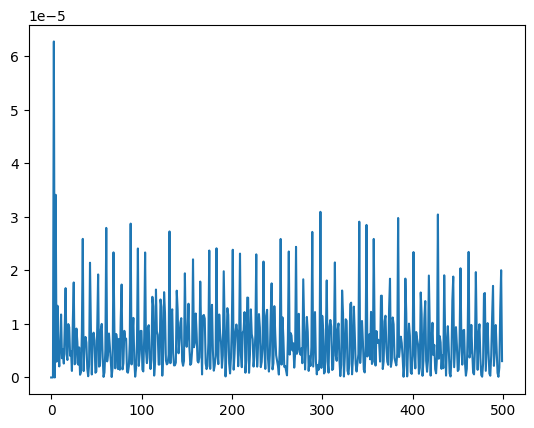

In [93]:
plt.plot(unitary_scores_array.flatten())

In [94]:
unitary_scores_array[-1]

(3.055746130797843e-06-3.0742387724329604e-21j)

In [95]:
overlap_scores_array = np.array(overlap_scores)

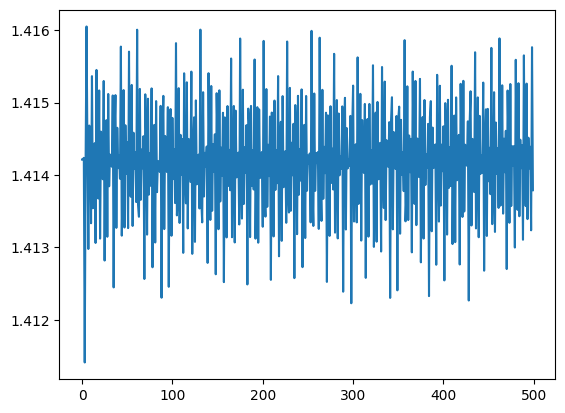

In [96]:
plt.plot(overlap_scores_array.flatten())

In [99]:
overlap_scores_array[-1]

1.4137899217379883

Hyperparamters look off, but otherwise good!

## Perturbed Solution test

In [100]:
num_sites = 2

In [101]:
total_dimension = 2**num_sites

In [102]:
num_iterations = 500

In [103]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 1),] + [(1, None),]

In [104]:
X_1 = np.array([[[1,],[0,]],[[0,],[-1,]]])

In [105]:
X_1.shape

(2, 2, 1)

In [106]:
w_1 = npc.Array.from_ndarray_trivial(X_1, labels=['p', 'p*', 'vR'])

In [107]:
w_2 = get_identity_w_tensor(2, left_virtual_dim=1)

In [108]:
sol_w_tensors = [w_1, w_2]

In [109]:
perturbations = get_random_mpo_tensors(physical_dims, virtual_dims)

In [110]:
w_1

<npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vR']>

In [111]:
w_2

<npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vL']>

In [112]:
perturbations

[<npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vL']>]

In [113]:
w_tensors = [
    w1 + 0.05*w2
    for w1, w2 in zip(sol_w_tensors, perturbations)
]

In [114]:
mpo_frobenius_inner_product(w_tensors)

(4.834322980845772-5.763757929884581e-18j)

In [115]:
total_dimension

4

In [116]:
w_tensors

[<npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vL']>]

In [117]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [118]:
b_tensors

[<npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>]

In [119]:
unitarity_learning_rate = 1
overlap_learning_rate = 1

In [120]:
adam_params = (1e-3, 0.3, 0.3)

In [121]:
adam_optimizers = [
    AdamTenpy(*adam_params) for _ in range(num_sites)
]

In [122]:
unitarity_scores, overlap_scores = (list(), list())

In [123]:
for _ in range(num_iterations):
    unitarity, overlap = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        np.sqrt(2),
        test_case.right_projected_symmetry_state,
        adam_optimizers
    )

    unitarity_scores.append(unitarity)
    overlap_scores.append(overlap)

In [124]:
unitary_scores_array = np.array(unitarity_scores)

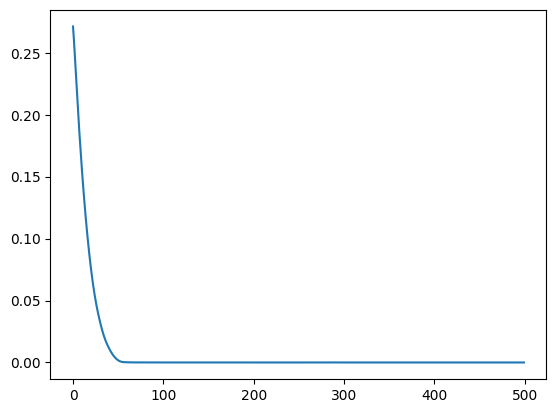

In [125]:
plt.plot(unitary_scores_array.flatten())

In [126]:
unitary_scores_array[-1]

(1.3126172193622665e-06-5.436156399040129e-18j)

In [127]:
overlap_scores_array = np.array(overlap_scores)

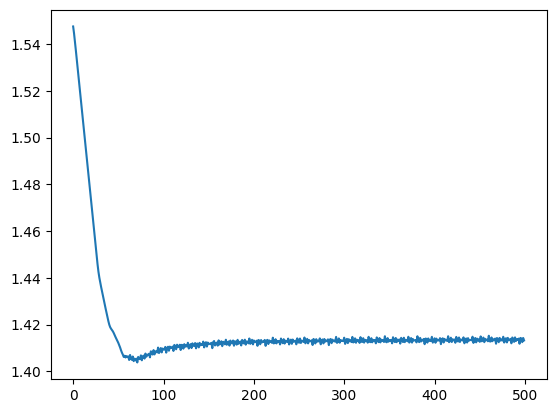

In [128]:
plt.plot(overlap_scores_array.flatten())

In [129]:
overlap_scores_array[-1]

1.4132328146589352

Looks good!

## Perturbed Solution test, more sites and bond dimensions

In [130]:
num_sites = 5

In [131]:
total_dimension = 2**num_sites

In [132]:
num_iterations = 500

In [133]:
bond_dimension=4

In [134]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 4),] + [(4,4)]*(num_sites - 2) + [(4, None),]

In [135]:
X_1 = np.zeros((2, 2, bond_dimension))
X_1[...,0] = np.array([[1, 0],[0, -1]])

In [136]:
X_1.shape

(2, 2, 4)

In [137]:
sol_w_tensors = [npc.Array.from_ndarray_trivial(X_1, labels=['p', 'p*', 'vR']),]

In [138]:
for pair in virtual_dims[1:]:
    sol_w_tensors.append(get_identity_w_tensor(2, *pair))

In [139]:
sol_w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [140]:
perturbations = get_random_mpo_tensors(physical_dims, virtual_dims)

In [141]:
perturbations

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [142]:
w_tensors = [
    w1 + 0.05*w2
    for w1, w2 in zip(sol_w_tensors, perturbations)
]

In [143]:
mpo_frobenius_inner_product(w_tensors)

(39.25935650433382-1.1102230246251565e-15j)

In [144]:
total_dimension

32

In [145]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [146]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [147]:
b_tensors

[<npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>]

In [148]:
unitarity_learning_rate = 1
overlap_learning_rate = 1

In [149]:
adam_params = (1e-3, 0.3, 0.3)

In [150]:
adam_optimizers = [
    AdamTenpy(*adam_params) for _ in range(num_sites)
]

In [151]:
unitarity_scores, overlap_scores = (list(), list())

In [152]:
for _ in range(num_iterations):
    unitarity, overlap = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        np.sqrt(2),
        test_case.right_projected_symmetry_state,
        adam_optimizers
    )

    unitarity_scores.append(unitarity)
    overlap_scores.append(overlap)

In [153]:
unitary_scores_array = np.array(unitarity_scores)

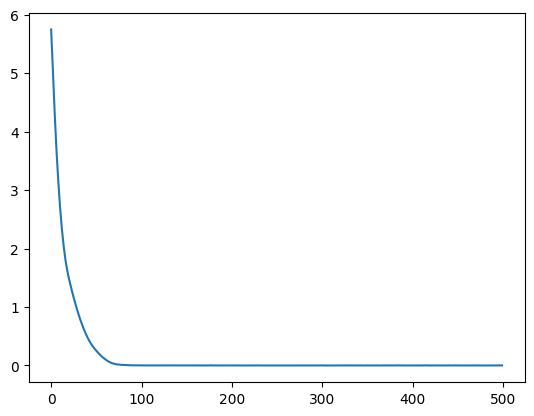

In [154]:
plt.plot(unitary_scores_array.flatten())

In [155]:
unitary_scores_array[-1]

(0.001190392833944287-1.3322676295501878e-15j)

In [156]:
overlap_scores_array = np.array(overlap_scores)

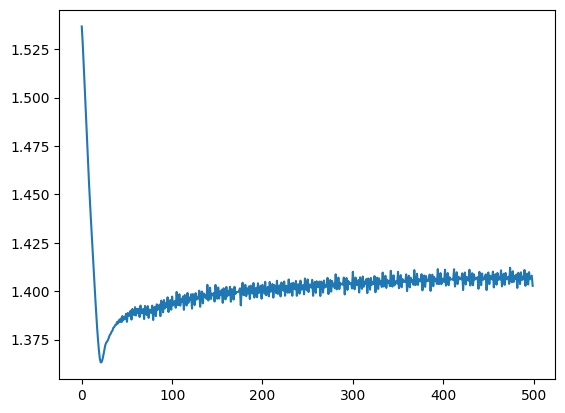

In [157]:
plt.plot(overlap_scores_array.flatten())

In [158]:
overlap_scores_array[-1]

1.402756856450371

Still looks good!

## Perturbed Solution test, more sites and bond dimensions, larger perturbation

In [185]:
num_sites = 5

In [186]:
total_dimension = 2**num_sites

In [187]:
num_iterations = 500

In [188]:
bond_dimension=4

In [189]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 4),] + [(4,4)]*(num_sites - 2) + [(4, None),]

In [190]:
X_1 = np.zeros((2, 2, bond_dimension))
X_1[...,0] = np.array([[1, 0],[0, -1]])

In [191]:
X_1.shape

(2, 2, 4)

In [192]:
sol_w_tensors = [npc.Array.from_ndarray_trivial(X_1, labels=['p', 'p*', 'vR']),]

In [193]:
for pair in virtual_dims[1:]:
    sol_w_tensors.append(get_identity_w_tensor(2, *pair))

In [194]:
sol_w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [195]:
perturbations = get_random_mpo_tensors(physical_dims, virtual_dims)

In [196]:
perturbations

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [197]:
w_tensors = [
    w1 + 0.5*w2
    for w1, w2 in zip(sol_w_tensors, perturbations)
]

In [198]:
mpo_frobenius_inner_product(w_tensors)

(19039.329962779546+7.958078640513122e-13j)

In [199]:
total_dimension

32

In [200]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [201]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [202]:
b_tensors

[<npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>]

In [203]:
unitarity_learning_rate = 1
overlap_learning_rate = 1

In [204]:
adam_params = (1e-3, 0.3, 0.3)

In [205]:
adam_optimizers = [
    AdamTenpy(*adam_params) for _ in range(num_sites)
]

In [206]:
unitarity_scores, overlap_scores = (list(), list())

In [222]:
for _ in range(num_iterations):
    unitarity, overlap = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        np.sqrt(2),
        test_case.right_projected_symmetry_state,
        adam_optimizers
    )

    unitarity_scores.append(unitarity)
    overlap_scores.append(overlap)

In [223]:
unitary_scores_array = np.array(unitarity_scores)

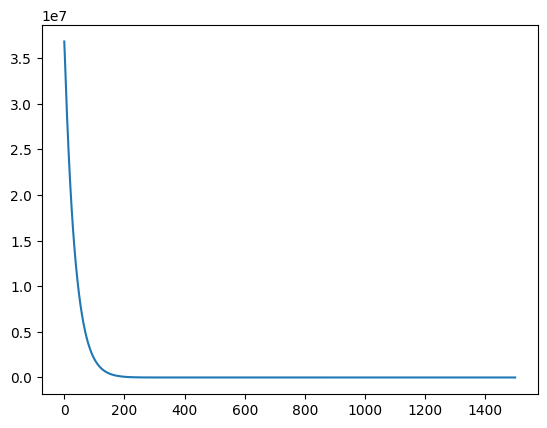

In [224]:
plt.plot(unitary_scores_array.flatten())

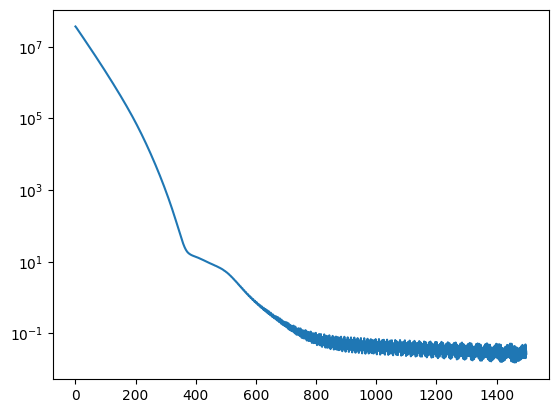

In [225]:
plt.plot(unitary_scores_array.flatten())
plt.yscale('log')

In [226]:
unitary_scores_array[-1]

(0.026593413308322766+1.6511236822225328e-12j)

In [227]:
overlap_scores_array = np.array(overlap_scores)

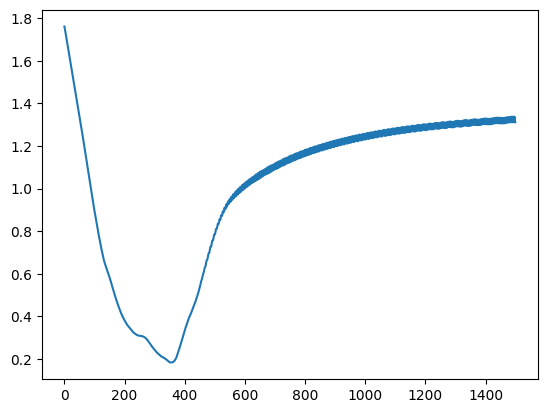

In [228]:
plt.plot(overlap_scores_array.flatten())

In [229]:
overlap_scores_array[-1]

1.311581828834931

Not bad!

# Load harder case

In [230]:
f_name = DATA_DIR + r"/1_20.h5"

In [231]:
f_name

'../../data/transverse_cluster_200_site_dmrg/1_20.h5'

In [232]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

In [249]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

In [250]:
test_case = SymmetryActionWithBoundaryUnitaries(
    test_psi,
    symmetry_actions[1]*50,
    left_boundary_unitaries=[np_I,]*3,
    right_boundary_unitaries=[np_I,]*3
)

In [251]:
test_case.compute_svd_approximate_expectation()

(0.7490571268992677-0j)

In [252]:
sing_val = test_case.symmetry_transfer_matrix_singular_vals[0]
target = np.power(sing_val, -1/2)

In [253]:
target

1.1435095362066725

# Harder tests

## B=1.2, 10 sites

In [560]:
num_sites = 10

In [561]:
total_dimension = 2**num_sites

In [562]:
num_iterations = 500

In [563]:
bond_dimension=4

In [564]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [565]:
mpo_tensors = get_random_mpo_tensors(physical_dims, virtual_dims)

In [566]:
rescale_mpo_tensors(mpo_tensors, 1)

In [567]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [568]:
unitarity_learning_rate = 1
overlap_learning_rate = 10

In [569]:
adam_params = (1e-3, 0.4, 0.4)

In [570]:
adam_optimizers = [
    AdamTenpy(*adam_params) for _ in range(num_sites)
]

In [571]:
unitarity_scores, overlap_scores = (list(), list())

In [572]:
mpo_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [573]:
b_tensors

[<npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>]

In [574]:
test_case.right_projected_symmetry_state

<npc.Array shape=(8, 8) labels=['vR', 'vR*']>

In [575]:
for i in range(num_iterations):
    unitarity, overlap = mpo_gradient_descent_sweep(
        mpo_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        target,
        test_case.right_projected_symmetry_state,
        adam_optimizers
    )

    unitarity_scores.append(unitarity)
    overlap_scores.append(overlap)

In [576]:
unitary_scores_array = np.array(unitarity_scores)

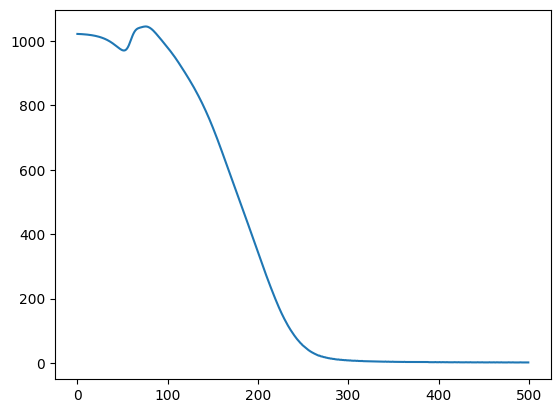

In [577]:
plt.plot(unitary_scores_array.flatten())

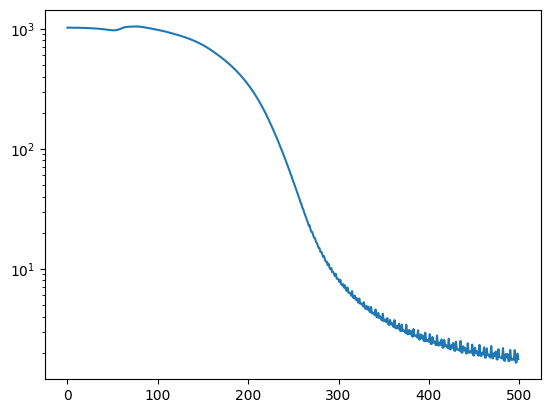

In [578]:
plt.plot(unitary_scores_array.flatten())
plt.yscale('log')

In [579]:
unitary_scores_array[-1]

(1.7711987524766073-2.1316282072803006e-13j)

In [580]:
overlap_scores_array = np.array(overlap_scores)

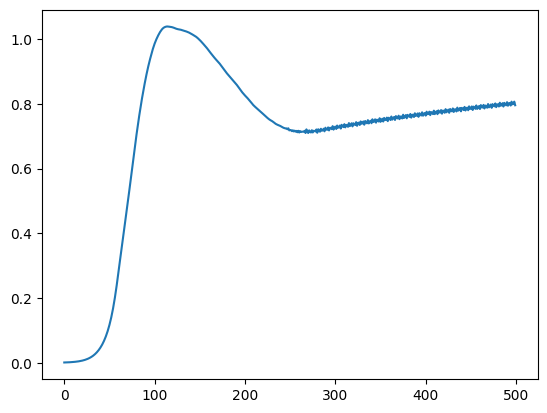

In [581]:
plt.plot(overlap_scores_array.flatten())

In [582]:
overlap_scores_array[-1]

0.7956181735289289

In [583]:
target

1.1435095362066725

## B=1.2, 6 sites

In [584]:
num_sites = 6

In [585]:
total_dimension = 2**num_sites

In [586]:
num_iterations = 500

In [587]:
bond_dimension=4

In [588]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [589]:
mpo_tensors = get_random_mpo_tensors(physical_dims, virtual_dims)

In [590]:
rescale_mpo_tensors(mpo_tensors, 1)

In [591]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [592]:
unitarity_learning_rate = 1
overlap_learning_rate = 10

In [593]:
adam_params = (1e-3, 0.4, 0.4)

In [594]:
adam_optimizers = [
    AdamTenpy(*adam_params) for _ in range(num_sites)
]

In [595]:
unitarity_scores, overlap_scores = (list(), list())

In [597]:
for i in range(num_iterations):
    unitarity, overlap = mpo_gradient_descent_sweep(
        mpo_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        target,
        test_case.right_projected_symmetry_state,
        adam_optimizers
    )

    unitarity_scores.append(unitarity)
    overlap_scores.append(overlap)

In [598]:
unitary_scores_array = np.array(unitarity_scores)

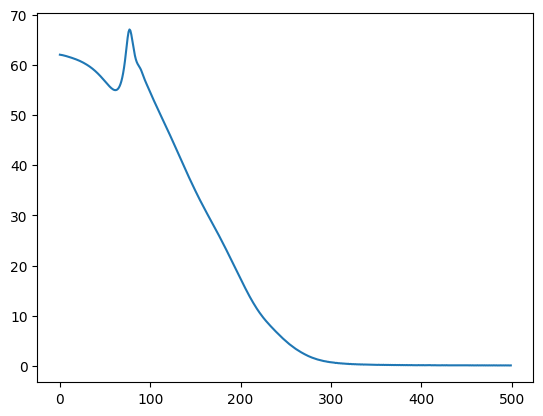

In [599]:
plt.plot(unitary_scores_array.flatten())

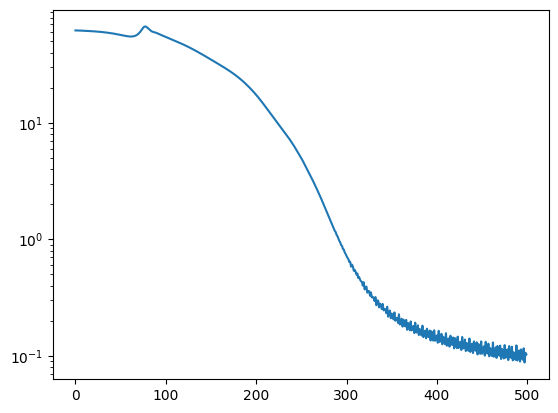

In [600]:
plt.plot(unitary_scores_array.flatten())
plt.yscale('log')

In [601]:
unitary_scores_array[-1]

(0.10281913011978361-5.329070518200751e-15j)

In [602]:
overlap_scores_array = np.array(overlap_scores)

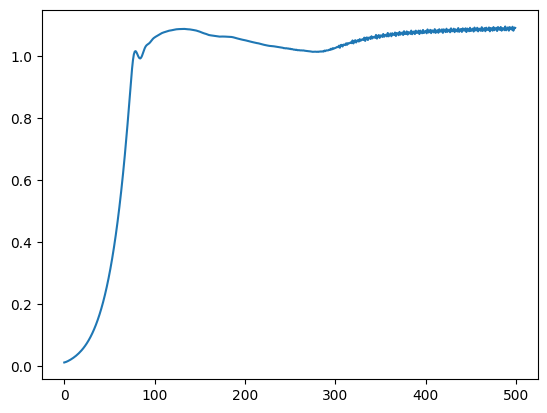

In [603]:
plt.plot(overlap_scores_array.flatten())

In [604]:
overlap_scores_array[-1]

1.0912526370359763

In [605]:
target

1.1435095362066725

Much better. So getting estimating the number of sites required is important.

## B=1.2, 10 sites, random initialisation

In [615]:
num_sites = 8

In [616]:
total_dimension = 2**num_sites

In [617]:
num_iterations = 500

In [618]:
bond_dimension=4

In [619]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [620]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [621]:
adam_params = (1e-3, 0.4, 0.4)

In [622]:
unitarity_learning_rate = 1
overlap_learning_rate = 10

In [623]:
num_initialisations = 100

In [624]:
best_score = 1e10

unitary_scores = list()
overlap_scores = list()

In [626]:
for i in range(num_initialisations):
    if i % 10 == 0:
        print(i)

    mpo_tensors = get_random_mpo_tensors(physical_dims, virtual_dims)
    rescale_mpo_tensors(mpo_tensors, 1)

    adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    current_unitarity_scores = list()
    current_overlap_scores = list()

    for i in range(num_iterations):
        unitarity, overlap = mpo_gradient_descent_sweep(
            mpo_tensors,
            b_tensors,
            unitarity_learning_rate,
            overlap_learning_rate,
            target,
            test_case.right_projected_symmetry_state,
            adam_optimizers
        )
    
        current_unitarity_scores.append(unitarity)
        current_overlap_scores.append(overlap)

    unitary_scores.append(unitarity)
    overlap_scores.append(overlap)

    current_score = (
        unitarity_learning_rate*(np.sqrt(unitarity + 1) -1)
        + overlap_learning_rate*((target)**2)
    )

    if current_score < best_score:
        best_score = current_score
        best_unitarity_scores = current_unitarity_scores 
        best_overlap_scores = current_overlap_scores 

    

0
10
20
30
40
50
60
70
80
90


In [627]:
best_score

(13.15160145000311+3.3034337408230543e-15j)

In [628]:
unitary_scores_array = np.array(best_unitarity_scores)

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


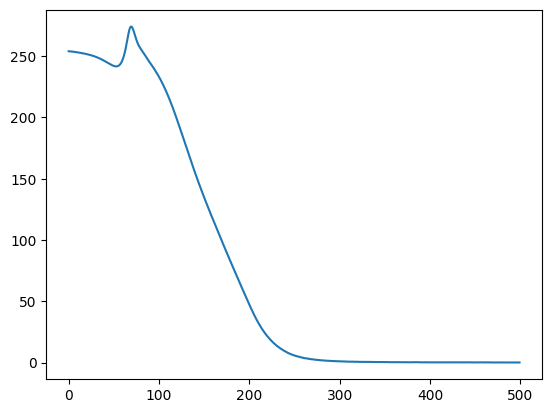

In [629]:
plt.plot(unitary_scores_array.flatten())

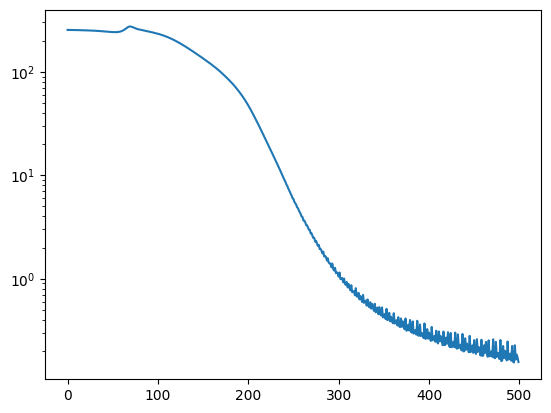

In [630]:
plt.plot(unitary_scores_array.flatten())
plt.yscale('log')

In [631]:
unitary_scores_array[-1]

(0.15661605288960345+7.105427357601002e-15j)

In [632]:
overlap_scores_array = np.array(best_overlap_scores)

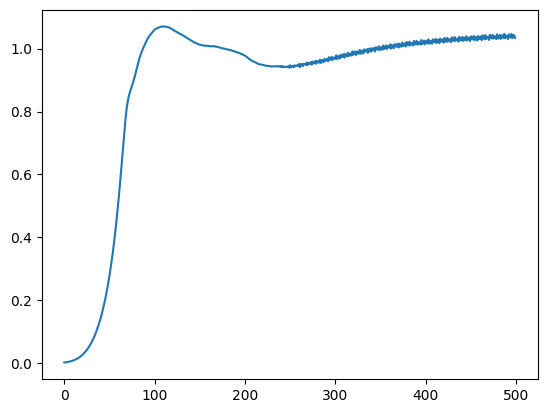

In [633]:
plt.plot(overlap_scores_array.flatten())

In [634]:
overlap_scores_array[-1]

1.0339326003284974

In [635]:
target

1.1435095362066725

In [640]:
pd.Series(np.real(np.array(current_unitarity_scores))).describe()

count    500.000000
mean      96.382175
std      107.086269
min        0.206433
25%        0.532842
50%       31.319256
75%      225.153386
max      283.466362
dtype: float64

In [641]:
pd.Series(np.real(np.array(current_overlap_scores))).describe()

count    500.000000
mean       0.860389
std        0.316202
min        0.002322
25%        0.933955
50%        0.993191
75%        1.020877
max        1.060720
dtype: float64

Random initialization can have a big impact on performance, along with selecting the right number of sites.

# Conclusions
* Appears to be working! Hyperparameter dependent though...